<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/04_SpeechTimeSeries/LSTM_text_classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM for Text Classification

1. Text Processing
2. Embeddings
3. LSTM network to classify recipes into cusines

In [0]:
# If using Colab, run this cell
%tensorflow_version 2.x

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
    
sns.set_style('whitegrid')

# for cleaning (e.g. stopword removal)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk import word_tokenize

# Classification stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow.keras as keras

# make sequences the same length by padding with 0s or truncating
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenise using keras (creates word index for embeddings)
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset

Source: https://github.com/stevenjson/CuisineClassifying/tree/master/Data

We will be classifying recipes for 3 cuisines: French, Indian, Japanese

In [21]:
# Run this if in Colab
!wget -O french.txt https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/cuisine/french.txt
!wget -O indian.txt https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/cuisine/indian.txt
!wget -O japanese.txt https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/cuisine/japanese.txt

# If not in Colab, download the files manually from the link above
# and put it in the same location as this notebook

--2020-01-14 01:48:23--  https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/cuisine/french.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202021 (197K) [text/plain]
Saving to: ‘french.txt’

french.txt          100%[===================>] 197.29K  --.-KB/s    in 0.02s   

2020-01-14 01:48:23 (8.99 MB/s) - ‘french.txt’ saved [202021/202021]

--2020-01-14 01:48:25--  https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/cuisine/indian.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119960 (117K) [te

In [0]:
# the files are just lines with 1 recipes in each line, so we have to load them slightly differently from the usual pandas route
def file_to_array(path):
    '''Opens a file and returns lines as a numpy array'''
    with open(path, 'r') as f:
        result = f.readlines()
    return np.array(result)

In [0]:
french = file_to_array('./french.txt')
japanese = file_to_array('./japanese.txt')
indian = file_to_array('./indian.txt')

In [24]:
# inspect any recipe
indian[2]

'1 (.25 ounce) package active dry yeast 1 cup warm water 1/4 cup white sugar 3 tablespoons milk 1 egg , beaten 2 teaspoons salt 4 1/2 cups bread flour 2 teaspoons minced garlic (optional) 1/4 cup butter , melted  | In a large bowl , dissolve yeast in warm water . Let stand about 10 minutes , until frothy . Stir in sugar , milk , egg , salt , and enough flour to make a soft dough . Knead for 6 to 8 minutes on a lightly floured surface , or until smooth . Place dough in a well oiled bowl , cover with a damp cloth , and set aside to rise . Let it rise 1 hour , until the dough has doubled in volume . Punch down dough , and knead in garlic . Pinch off small handfuls of dough about the size of a golf ball . Roll into balls , and place on a tray . Cover with a towel , and allow to rise until doubled in size , about 30 minutes . During the second rising , preheat grill to high heat . At grill side , roll one ball of dough out into a thin circle . Lightly oil grill . Place dough on grill , and 

In [25]:
# how to create a list of N same values
5*['hello']

['hello', 'hello', 'hello', 'hello', 'hello']

In [26]:
# how to create labels
len(french) * ['french']

['french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',

In [27]:
# how to create a dataframe with receipes and cusine label
labels = len(french) * ['french']

pd.DataFrame({'recipe': french, 'cusine': labels}).head()

,recipe,cusine
0,1 cup all-purpose flour 5 eggs 1/4 cup milk 3/...,french
1,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french
2,"4 russet potatoes , sliced into 1/4 inch slice...",french
3,1 recipe pastry for a 9 inch single crust pie ...,french
4,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french


In [28]:
# concat all 3 cusines into 1 single dataframe

df = pd.concat([
    pd.DataFrame({'recipe': french, 'cusine':len(french) * ['french']}),
    pd.DataFrame({'recipe': japanese, 'cusine':len(japanese) * ['japanese']}),
    pd.DataFrame({'recipe': indian, 'cusine':len(indian) * ['indian']})
], axis=0) # axis=0 is by row 

# optionally reset index to 0 to 419
df.reset_index(inplace=True, drop=True)

# df.sample(frac=1.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
recipe    420 non-null object
cusine    420 non-null object
dtypes: object(2)
memory usage: 6.7+ KB


In [29]:
df['cusine'].value_counts()

french      180
indian      120
japanese    120
Name: cusine, dtype: int64

## Data Preprocessing

- Stopword removal
- Lemmatization, stemming (left as an exercise for you)
- Vectorization

In [0]:
def clean_stopwords(text):
    '''Remove stop words from a text'''
    stoplist = set(stopwords.words('english'))

    tokens = word_tokenize(text)
    
    # if lowercase of token is not in stoplist: (i.e. not a stopword)
    #    keep the token
    #
    # we keep only tokens that are not in the stopword list
    # ' '.join() creates a string out of a list
    return ' '.join([t for t in tokens if (t.lower() not in stoplist)])

In [31]:
#
# apply the clean_stopwords function on the 'recipe' column
#

# df['recipe'].apply(func) will apply func on every row (without manually looping dataframe)
df['recipe'] = df['recipe'].apply(clean_stopwords)
df['recipe']

0      1 cup all-purpose flour 5 eggs 1/4 cup milk 3/...
1      2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...
2      4 russet potatoes , sliced 1/4 inch slices 1 o...
3      1 recipe pastry 9 inch single crust pie 6 slic...
4      2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...
                             ...                        
415    2 bunches spinach , roughly chopped 1 bunch fe...
416    2 tomatoes , diced 1 onion , chopped 1 ( 1 inc...
417    1 1/2 pounds skinless , boneless chicken breas...
418    1 cup fat-free plain yogurt 1/2 tablespoon cay...
419    1 cup red lentils 1 cup brown lentils 8 cups w...
Name: recipe, Length: 420, dtype: object

### Vectorization

1) Tokenization to convert text to a sequence https://keras.io/preprocessing/text/

2) WordEmbeddings: create dense representation of the sequence

### Tokenizer

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [32]:
# Steps:
# 1. Initialise the Tokenizer with a max vocabulary size
# 2. fit_on_texts
# 3. text_to_sequences

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['recipe'])

# df['recipe']
# tokenizer.texts_to_sequences(df['recipe'])
df['sequences'] = tokenizer.texts_to_sequences(df['recipe'])
df.head()

,recipe,cusine,sequences
0,1 cup all-purpose flour 5 eggs 1/4 cup milk 3/...,french,"[1, 3, 119, 120, 33, 36, 81, 1, 7, 3, 60, 8, 7..."
1,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french,"[2, 37, 90, 12, 1, 6, 32, 2, 1, 2, 13, 511, 11..."
2,"4 russet potatoes , sliced 1/4 inch slices 1 o...",french,"[7, 869, 112, 58, 1, 7, 55, 100, 1, 23, 58, 75..."
3,1 recipe pastry 9 inch single crust pie 6 slic...,french,"[1, 965, 221, 361, 55, 705, 404, 405, 71, 100,..."
4,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french,"[2, 37, 90, 12, 1, 6, 32, 2, 1, 2, 13, 511, 11..."


In [33]:
df['sequences'].shape

(420,)

In [34]:
# show the vocabulary (index <-> word mapping)
tokenizer.word_index

{'1': 1,
 '2': 2,
 'cup': 3,
 'minutes': 4,
 'heat': 5,
 'teaspoon': 6,
 '4': 7,
 '3': 8,
 'salt': 9,
 'stir': 10,
 'chicken': 11,
 'oil': 12,
 'tablespoons': 13,
 'pepper': 14,
 'cook': 15,
 'water': 16,
 'medium': 17,
 'tablespoon': 18,
 'sugar': 19,
 'skillet': 20,
 'add': 21,
 'sauce': 22,
 'onion': 23,
 'degrees': 24,
 'large': 25,
 'place': 26,
 'garlic': 27,
 'chopped': 28,
 'ground': 29,
 'bowl': 30,
 'mixture': 31,
 'butter': 32,
 'flour': 33,
 'oven': 34,
 'cups': 35,
 '5': 36,
 'teaspoons': 37,
 'cover': 38,
 'rice': 39,
 'white': 40,
 'fresh': 41,
 '10': 42,
 'pour': 43,
 'ginger': 44,
 'powder': 45,
 'taste': 46,
 'mix': 47,
 'simmer': 48,
 'cheese': 49,
 'together': 50,
 'cream': 51,
 'ounce': 52,
 'egg': 53,
 'pan': 54,
 'inch': 55,
 'high': 56,
 'remove': 57,
 'sliced': 58,
 'f': 59,
 'milk': 60,
 'c': 61,
 'cut': 62,
 'onions': 63,
 'brown': 64,
 'dough': 65,
 'black': 66,
 'bring': 67,
 'wine': 68,
 'baking': 69,
 'paste': 70,
 '6': 71,
 'soy': 72,
 'low': 73,
 'top':

In [35]:
# actual vocabulary size
len(tokenizer.word_index)

2188

### Embeddings

Steps to use Embeddings:
1. Make sure all sequences are the same length. We need to pick a fixed sequence length.
    Options:
     - pick the max, pad the rest 
     - pick the some N, truncate text longer than N, pad text shorter than N.
     
2. Create an Embedding layer as the first layer of your Neural Network
3. Pass the sequence (not the text) directly to the Embedding layer

#### Padding Sequences

All sequences need to be the same length

Options:
 - pick the max length. All shorter sequences will be padding
 - pick N < max, truncate sequences longer than N, pad sequences shorter than N.
 
Notable settings:
 - pre-padding or post-padding. Most select 'pre' padding so that the output hidden state does not go to zero (intuition: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results)
 - the value to use for padding. Default is 0, which maps to no word.

In [0]:
# pad_sequences?

In [0]:
# len(pad_sequences(df['sequences'])[2]), len(df['sequences'][2])

In [36]:
df['sequences'].shape

(420,)

In [37]:
# you can specify a maximum length, which will truncate sequences longer it
# pad_sequences(df['sequences'], maxlen=400, padding='post')
pad_sequences(df['sequences']).shape

(420, 458)

In [0]:
X = pad_sequences(df['sequences'])

In [40]:
X.shape

(420, 458)

In [0]:
# to_categorical expects numbers, not strings
le = LabelEncoder()
y_encoded = le.fit_transform(df['cusine'])
y = to_categorical(y_encoded) # multi-class, need to_categorical

In [42]:
y.shape

(420, 3)

In [43]:
le.classes_

array(['french', 'indian', 'japanese'], dtype=object)

In [44]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

#### Train-test-split

Consider: why do we not care about shuffling here?

What is the difference between this and time series?

In [0]:
# stratify so that test and train have same class proportions 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [46]:
y_test.shape

(105, 3)

### Model

Good explanation from: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

- input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.


- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.


- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [0]:
len(tokenizer.word_index) # vocab (2190 unique words)

2190

In [47]:
X_train.shape # 315 is number of rows (recipes), 458 sequence length (recipe length)

(315, 458)

In [48]:
# 0 is not part of the word_index because convention is to use 0 for out-of-vocab words
# OOV words = words not in the word_index
tokenizer.word_index

# Notice that 0 is reserved for you (use for OOV)
# {'1': 1,
# '2': 2,
# 'cup': 3,
# 'minutes': 4,

# Therefore, vocab size needs to be plus 1 (include the 0)
#
# vocab_size_with_OOV_token = len(tokenizer.word_index) + 1
# word_vector_len = 10 (size of each word vector)
# Embedding(vocab_size=vocab_size_with_OOV_token, output_dim=word_vector_len)
# i.e.
# Embedding(vocab_size=2191, output_dim=10)
#
# note: sequence length will be dealt with at the RNN

{'1': 1,
 '2': 2,
 'cup': 3,
 'minutes': 4,
 'heat': 5,
 'teaspoon': 6,
 '4': 7,
 '3': 8,
 'salt': 9,
 'stir': 10,
 'chicken': 11,
 'oil': 12,
 'tablespoons': 13,
 'pepper': 14,
 'cook': 15,
 'water': 16,
 'medium': 17,
 'tablespoon': 18,
 'sugar': 19,
 'skillet': 20,
 'add': 21,
 'sauce': 22,
 'onion': 23,
 'degrees': 24,
 'large': 25,
 'place': 26,
 'garlic': 27,
 'chopped': 28,
 'ground': 29,
 'bowl': 30,
 'mixture': 31,
 'butter': 32,
 'flour': 33,
 'oven': 34,
 'cups': 35,
 '5': 36,
 'teaspoons': 37,
 'cover': 38,
 'rice': 39,
 'white': 40,
 'fresh': 41,
 '10': 42,
 'pour': 43,
 'ginger': 44,
 'powder': 45,
 'taste': 46,
 'mix': 47,
 'simmer': 48,
 'cheese': 49,
 'together': 50,
 'cream': 51,
 'ounce': 52,
 'egg': 53,
 'pan': 54,
 'inch': 55,
 'high': 56,
 'remove': 57,
 'sliced': 58,
 'f': 59,
 'milk': 60,
 'c': 61,
 'cut': 62,
 'onions': 63,
 'brown': 64,
 'dough': 65,
 'black': 66,
 'bring': 67,
 'wine': 68,
 'baking': 69,
 'paste': 70,
 '6': 71,
 'soy': 72,
 'low': 73,
 'top':

In [0]:
# vocabulary: remember to add 1 for the padding token (0)
# tokenizer.word_index excludes 0
# Embedding layer needs to know about 0, and the 2190 vocab index
# New words not found in training set will be ignored
input_dim = len(tokenizer.word_index) + 1

# output of the embedding layer
# compress my 2191 vocab (one-hot) recipe into 100-sized vector
# Each recipe is 458 long, can be any of 2191 vocab
#
# 458 x 2191 is a sparse matrix
# Embedding will output a tensor of 458x100
# use as input directly into LSTM
#
output_dim = 10

# length of the sequence
input_length = X.shape[1] # sequence length
                          # X.shape returns (rows, cols)
                          # X.shape[1] returns cols

In [50]:
# example
Embedding(input_dim, output_dim, input_length=input_length)

# Party Time!

Model architecture:
1. Embedding with the above settings (must be first layer)
2. LSTM (pick a small number of output neurons)
3. 2-layer Dense MLP with the appropriate activation type and the correct number of output classes
4. Compile the model
5. Fit it using X_train, y_train. Validate using X_test, y_test. Optionally set callbacks, etc.
6. Evaluate metrics

Notes:
- You may refer to https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/ for an example
- This model may train quite slowly, may want to try only 10-20 epochs at time. You can always call fit multiple times.
- Feel free to experiment with stacked LSTM, multiple Dense layers, etc

In [52]:
# define your model, compile, and fit it (10-15 epochs should be enough for a decent model)
num_classes=3
model = Sequential()

# Embedding
model.add(Embedding(input_dim, output_dim, input_length=input_length)) # embedding dim = 10
# RNN
model.add(LSTM(32)) # 32 is the size of the output and hidden state
# MLP
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # use loss=categorical_entropy
model.summary()

# Stacked LSTM
model1 = Sequential()
# Embedding
model1.add(Embedding(input_dim, output_dim, input_length=input_length))
# RNN (Stacked LSTM)
model1.add(LSTM(32, return_sequences=True))
model1.add(LSTM(32))
# MLP
model1.add(Dense(32, activation='relu'))
model1.add(Dense(3, activation='softmax')) # use loss=categorical_entropy
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 458, 10)           21890     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 28,549
Trainable params: 28,549
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 458, 10)           21890     
____________________________

In [0]:
# compile your model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Create model checkpoint
mc = ModelCheckpoint('./cusines_lstm.h5', save_best_only=True)
mc1 = ModelCheckpoint('./cusines_stacked_lstm.h5', save_best_only=True)

In [55]:
# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[mc])

Train on 315 samples, validate on 105 samples
Epoch 1/20
315/315 [==============================] - 4s 13ms/sample - loss: 1.0951 - accuracy: 0.3714 - val_loss: 1.0875 - val_accuracy: 0.4286
Epoch 2/20
315/315 [==============================] - 2s 6ms/sample - loss: 1.0725 - accuracy: 0.4317 - val_loss: 1.0596 - val_accuracy: 0.4286
Epoch 3/20
315/315 [==============================] - 2s 6ms/sample - loss: 1.0179 - accuracy: 0.4444 - val_loss: 1.0259 - val_accuracy: 0.5048
Epoch 4/20
315/315 [==============================] - 2s 6ms/sample - loss: 0.8998 - accuracy: 0.5175 - val_loss: 1.1980 - val_accuracy: 0.4286
Epoch 5/20
315/315 [==============================] - 2s 6ms/sample - loss: 0.8338 - accuracy: 0.6095 - val_loss: 0.8834 - val_accuracy: 0.5714
Epoch 6/20
315/315 [==============================] - 2s 6ms/sample - loss: 0.7196 - accuracy: 0.6540 - val_loss: 0.8702 - val_accuracy: 0.5905
Epoch 7/20
315/315 [==============================] - 2s 6ms/sample - loss: 0.6662 - accu

In [56]:
# fit the stacked model
# This tends to overfit, so you may consider dropout to improve validation scores
# Dropout will randomly set drop some output connections (by setting them to 0)

# The stacked LSTM tries to learn sequences from the intermediate output states
# rather than raw sequences.
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[mc1])

Train on 315 samples, validate on 105 samples
Epoch 1/20
315/315 [==============================] - 7s 22ms/sample - loss: 1.0893 - accuracy: 0.4190 - val_loss: 1.0737 - val_accuracy: 0.4286
Epoch 2/20
315/315 [==============================] - 4s 12ms/sample - loss: 1.0337 - accuracy: 0.4317 - val_loss: 0.9146 - val_accuracy: 0.4857
Epoch 3/20
315/315 [==============================] - 4s 12ms/sample - loss: 0.8935 - accuracy: 0.6413 - val_loss: 0.8356 - val_accuracy: 0.5810
Epoch 4/20
315/315 [==============================] - 4s 12ms/sample - loss: 0.7139 - accuracy: 0.6698 - val_loss: 0.8157 - val_accuracy: 0.5714
Epoch 5/20
315/315 [==============================] - 4s 12ms/sample - loss: 0.6212 - accuracy: 0.6825 - val_loss: 1.0509 - val_accuracy: 0.5810
Epoch 6/20
315/315 [==============================] - 4s 12ms/sample - loss: 0.5819 - accuracy: 0.7048 - val_loss: 0.6799 - val_accuracy: 0.6571
Epoch 7/20
315/315 [==============================] - 4s 12ms/sample - loss: 0.5127 

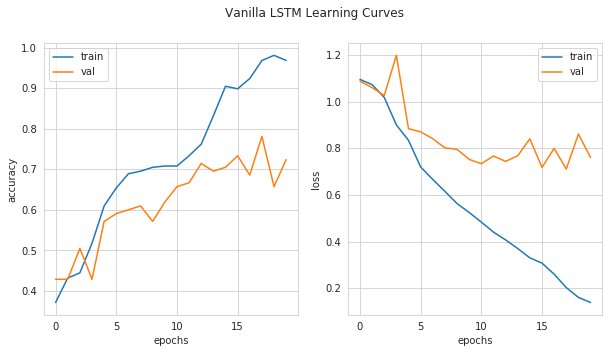

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

fig.suptitle('Vanilla LSTM Learning Curves')

ax[0].plot(history.history['accuracy'], label='train')
ax[0].plot(history.history['val_accuracy'], label='val')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='val')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epochs')
ax[1].legend()

plt.show()

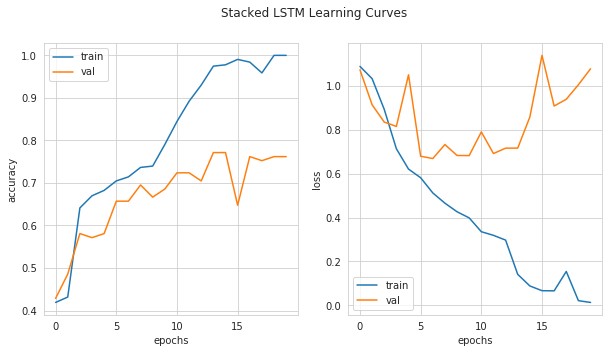

In [60]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle('Stacked LSTM Learning Curves')

ax[0].plot(history1.history['accuracy'], label='train')
ax[0].plot(history1.history['val_accuracy'], label='val')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend()

ax[1].plot(history1.history['loss'], label='train')
ax[1].plot(history1.history['val_loss'], label='val')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epochs')
ax[1].legend()

plt.show()


## Metrics

In [0]:
pred = model.predict_classes(X_test)

In [62]:
confusion_matrix(y_test.argmax(axis=1), pred)

array([[33, 10,  2],
       [ 3, 26,  1],
       [ 0, 13, 17]])

In [63]:
print(classification_report(y_test.argmax(axis=1), pred))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        45
           1       0.53      0.87      0.66        30
           2       0.85      0.57      0.68        30

    accuracy                           0.72       105
   macro avg       0.77      0.72      0.72       105
weighted avg       0.79      0.72      0.73       105



In [64]:
pred = model1.predict_classes(X_test)
print(confusion_matrix(y_test.argmax(axis=1), pred))
print(classification_report(y_test.argmax(axis=1), pred))

[[34  2  9]
 [ 0 23  7]
 [ 5  2 23]]
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        45
           1       0.85      0.77      0.81        30
           2       0.59      0.77      0.67        30

    accuracy                           0.76       105
   macro avg       0.77      0.76      0.76       105
weighted avg       0.79      0.76      0.77       105



## Predictions using real recipes

Try your model against these sample recipes from various websites

In [69]:
# https://www.epicurious.com/recipes/food/views/miso-soup-103391

recipe = '''
1/2 cup dried wakame (a type of seaweed)
1/4 cup shiro miso (white fermented-soybean paste)
6 cups Dashi.
1/2 pound soft tofu, drained and cut into 1/2-inch cubes.
1/4 cup thinly sliced scallion greens.
Stir together miso and 1/2 cup dashi in a bowl until smooth. Heat remaining dashi in a saucepan over moderately high heat until hot, then gently stir in tofu and reconstituted wakame. Simmer 1 minute and remove from heat. Immediately stir in miso mixture and scallion greens and serve.
'''

clean_stopwords(recipe)
recipe_input = tokenizer.texts_to_sequences([clean_stopwords(recipe)])
recipe_input_padded = pad_sequences(recipe_input, maxlen=input_length)
print('basic LSTM prediction', le.inverse_transform(model.predict_classes(recipe_input_padded)))
print('stacked LSTM prediction', le.inverse_transform(model1.predict_classes(recipe_input_padded)))

basic LSTM prediction ['japanese']
stacked LSTM prediction ['japanese']


In [68]:
# https://recipes.timesofindia.com/recipes/masala-chicken/rs54673639.cms

recipe = '''
1 1/4 kilograms washed & dried chicken
3 cup sliced onion
2 cup minced tomato
1 cup finely chopped coriander leaves
1 tablespoon garlic flakes
1 teaspoon cumin seeds
1 tablespoon chilli powder
1/2 teaspoon powdered turmeric
1/2 cup grated coconut
5 tablespoon refined oil
1/2 cup curry leaves
1 teaspoon salt
2 inches ginger
3/4 teaspoon mustard seeds
1 teaspoon peppercorns
3 tablespoon coriander powder
3/4 cup water
1 1/2 tablespoon poppy seeds

Step 1- Soak the chicken in lukewarm water to reduce the cooking time
Masala Chicken is one of the most delicious non-veg preparations. Made with some easily available ingredients. It might look difficult to prepare, but we have found the easiest recipe to prepare this amazing delicacy. Here’s how you can cook it, in the restaurant style at the convenience of your home. Soak the chicken pieces in some lukewarm water with a small pinch of salt, this will reduce the time required to cook the chicken and will make the pieces soft & tender. Then, clean and rinse the pieces properly.

Step 2- Make a paste of all the spices and a fresh coconut paste
Keep this cleaned chicken aside and make a paste of 2 pieces of ginger, garlic, mustard seeds, cumin seeds, and black peppercorn. Then take chilli powder, coriander powder, turmeric powder and a quarter cup of water. Grind them all and make a paste of it. Now, grind together grated fresh coconut and poppy seeds and make a fine paste of them.

Step 3- Cook the chicken with the spices paste and onions
Heat oil in a pressure cooker, fry onions till they turn golden brown. Then add curry leaves and salt, mix in the ginger-garlic spice paste and fry for three minutes. Now add chilli-coriander-turmeric powder paste. Mix thoroughly and add the chicken pieces. Fry for five minutes.

Step 4- Cook the chicken with coconut-poppy paste and tomatoes, and serve hot
Add tomatoes and fry for another five minutes with one and a half cups of water and cook for about 10-15 minutes. When the chicken is tender, mix in the coconut-poppy seed paste and cook over medium heat for five minutes. Finally, add coriander leaves, mix well and remove from heat. Serve hot with butter naan and raita. mutton mutton mutton
'''

recipe_input = tokenizer.texts_to_sequences([clean_stopwords(recipe)])
recipe_input_padded = pad_sequences(recipe_input, maxlen=input_length)
print('basic LSTM prediction', le.inverse_transform(model.predict_classes(recipe_input_padded)))
print('stacked LSTM prediction', le.inverse_transform(model1.predict_classes(recipe_input_padded)))

basic LSTM prediction ['japanese']
stacked LSTM prediction ['indian']


In [0]:
# not in the vocab (will give error)
# tokenizer.word_index['mutton']

#KeyError                                  Traceback (most recent call last)
#<ipython-input-103-078c3aabdaa4> in <module>
#      1 # not in the vocab
#----> 2 tokenizer.word_index['mutton']
#
#KeyError: 'mutton'

# Notice how the model still handles the input

In [0]:
# in the vocab
# tokenizer.word_index['chicken']

### Inspecting Embeddings

You can extract the embeddings and plot them using PCA or tensorflow projector to see the word vectors.

In [0]:
from tensorflow.keras.models import load_model

In [71]:
saved_model = load_model('./cusines_lstm.h5')
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 458, 10)           21890     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 28,549
Trainable params: 28,549
Non-trainable params: 0
_________________________________________________________________


In [72]:
saved_model.layers[0]

In [73]:
# embedding vectors
saved_model.layers[0].get_weights()

[array([[-0.02891629, -0.04243627,  0.00590757, ..., -0.01857266,
         -0.05748651,  0.00040783],
        [-0.02792195, -0.00798074,  0.03645893, ..., -0.03437311,
          0.03827392,  0.00708798],
        [-0.03831377, -0.04370154, -0.00807928, ...,  0.01567539,
         -0.00284726, -0.05058426],
        ...,
        [ 0.03311502, -0.02536776, -0.00392318, ..., -0.01470089,
          0.00776315, -0.01911725],
        [ 0.01518262, -0.01643542,  0.00955504, ..., -0.01097277,
          0.00284005, -0.01558585],
        [-0.0599299 , -0.01607409,  0.0040224 , ...,  0.02953637,
          0.0456307 , -0.02188467]], dtype=float32)]

In [74]:
import numpy as np
weights = np.array(saved_model.layers[0].get_weights())
weights.shape

(1, 2189, 10)

In [75]:
# remove the first dimension
vectors = weights[0]
vectors.shape

(2189, 10)

In [76]:
# get the vocab
vocab = list(tokenizer.word_index.keys())
vocab = ['PAD'] + vocab
vocab

['PAD',
 '1',
 '2',
 'cup',
 'minutes',
 'heat',
 'teaspoon',
 '4',
 '3',
 'salt',
 'stir',
 'chicken',
 'oil',
 'tablespoons',
 'pepper',
 'cook',
 'water',
 'medium',
 'tablespoon',
 'sugar',
 'skillet',
 'add',
 'sauce',
 'onion',
 'degrees',
 'large',
 'place',
 'garlic',
 'chopped',
 'ground',
 'bowl',
 'mixture',
 'butter',
 'flour',
 'oven',
 'cups',
 '5',
 'teaspoons',
 'cover',
 'rice',
 'white',
 'fresh',
 '10',
 'pour',
 'ginger',
 'powder',
 'taste',
 'mix',
 'simmer',
 'cheese',
 'together',
 'cream',
 'ounce',
 'egg',
 'pan',
 'inch',
 'high',
 'remove',
 'sliced',
 'f',
 'milk',
 'c',
 'cut',
 'onions',
 'brown',
 'dough',
 'black',
 'bring',
 'wine',
 'baking',
 'paste',
 '6',
 'soy',
 'low',
 'top',
 'reduce',
 'boil',
 'minced',
 'green',
 '8',
 'preheat',
 'eggs',
 'small',
 'hot',
 'cumin',
 'set',
 'saucepan',
 'vegetable',
 'mushrooms',
 'side',
 'olive',
 'bake',
 'red',
 '15',
 'browned',
 'dish',
 'tender',
 'stirring',
 'remaining',
 'season',
 'slices',
 'ser

In [77]:
df_embedding = pd.DataFrame(vectors)
df_embedding.index = vocab
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9
PAD,-0.028916,-0.042436,0.005908,-0.043732,-0.016579,0.040125,-0.018032,-0.018573,-0.057487,0.000408
1,-0.027922,-0.007981,0.036459,0.018429,-0.045163,0.039886,0.005316,-0.034373,0.038274,0.007088
2,-0.038314,-0.043702,-0.008079,0.043822,-0.010026,-0.030490,-0.006351,0.015675,-0.002847,-0.050584
cup,-0.013824,-0.019415,-0.027931,-0.053685,0.033184,-0.002981,0.019043,0.033955,-0.055853,-0.028054
minutes,-0.049718,0.023534,-0.004074,0.064498,0.013792,0.043308,-0.034248,-0.047325,0.015146,-0.020032


In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

vectors_2d = pca.fit_transform(vectors)
vectors_2d.shape

(2189, 2)

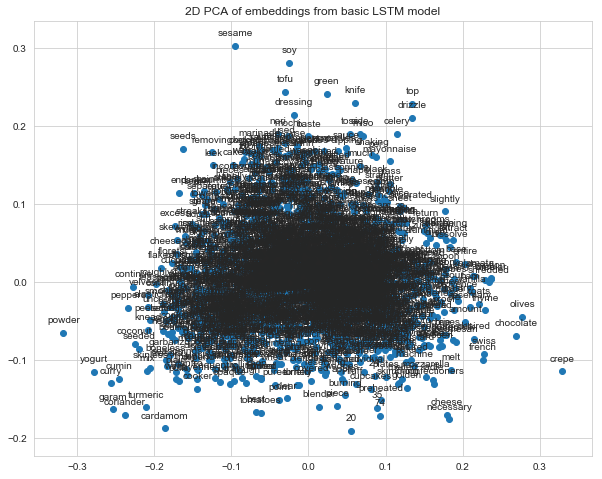

In [0]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
ax.set_title('2D PCA of embeddings from basic LSTM model')

for word, vector_2d in zip(vocab, vectors_2d):
    plt.annotate(word, # the text
                 (vector_2d[0], vector_2d[1]), # point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

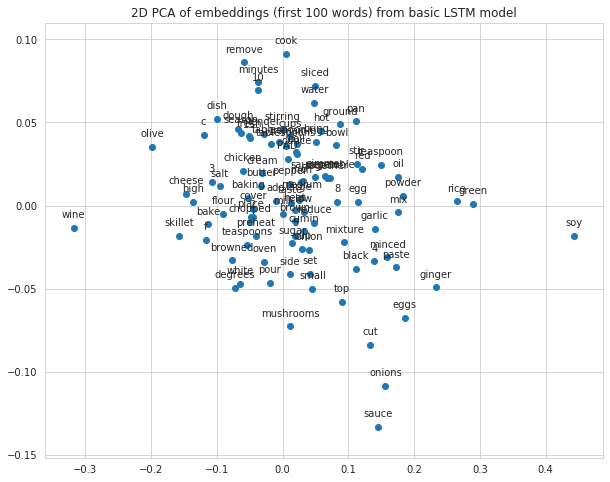

In [79]:
# first N words
limit = 100

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vectors_2d[:limit, 0], vectors_2d[:limit, 1])
ax.set_title(f'2D PCA of embeddings (first {limit} words) from basic LSTM model')

for word, vector_2d in zip(vocab[:limit], vectors_2d[:limit]):
    plt.annotate(word, # the text
                 (vector_2d[0], vector_2d[1]), # point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

In [0]:
# Can repeat exercise with the stacked LSTM model to see if anything different

#### Compute similar words

Reference: https://towardsdatascience.com/3-basic-distance-measurement-in-text-mining-5852becff1d7

In [80]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

eu_dist = cosine_similarity(df_embedding)
eu_dist.shape

(2189, 2189)

In [82]:
word = 'coffee'
index = (df_embedding.index == word).argmax() # find word's index in the embedding
                                              # argmax() will return the index
                                              # for True (there should be only 1)

# find distances for that word
distances = euclidean_distances(df_embedding)[index]
pd.Series(distances, index=df_embedding.index).sort_values()

coffee        0.000000
rimmed        0.076692
chopsticks    0.081323
fan           0.083825
drape         0.083983
                ...   
chocolate     0.453993
read          0.471061
crepe         0.472256
instant       0.475503
wine          0.482775
Length: 2189, dtype: float32

In [0]:
def get_similar_words(embedding, word, topN=10):
    '''# given a word, find the nearest N words'''
    index = (embedding.index == word).argmax()
    distances = euclidean_distances(embedding)[index]

    nearest = pd.Series(distances, index=df_embedding.index).sort_values()
    
    return nearest.iloc[:topN]

In [84]:
get_similar_words(df_embedding, 'coffee')

coffee        0.000000
rimmed        0.076692
chopsticks    0.081323
fan           0.083825
drape         0.083983
nori          0.085192
grease        0.090041
invert        0.090110
streaks       0.090204
butterfly     0.091573
dtype: float32

In [85]:
get_similar_words(df_embedding, 'curry')

curry      0.000000
fluid      0.052958
highest    0.065643
filets     0.067347
arrange    0.069655
way        0.070659
14         0.070674
wrap       0.071084
wakame     0.071333
gyoza      0.071699
dtype: float32

In [86]:
get_similar_words(df_embedding, 'chicken')

chicken       0.000000
fireplace     0.051377
croissant     0.057057
stalk         0.059569
bouquet       0.063524
mash          0.067015
style         0.068185
cornflakes    0.072998
puffed        0.075268
continuing    0.075617
dtype: float32

In [87]:
# What if the word is not in the index?
# It automatically gets assigned to the PAD index
get_similar_words(df_embedding, 'mutton')

PAD            0.000000
sea            0.068955
stockpot       0.075009
hellman's®     0.075516
beautifully    0.076481
potpourri      0.076926
shaping        0.077468
roma           0.078091
carrots        0.078611
harden         0.080109
dtype: float32

### Visualizing using Embedding Projector

http://projector.tensorflow.org/

Upload embeddings.tsv and embedding_metadata.tsv

In [0]:
df_embedding.to_csv('embeddings.tsv', sep='\t', columns=None, header=False, index=False)

In [0]:
df_embedding.to_csv('embedding_metadata.tsv', sep='\t', header=False, index=True, columns=[])

1. Go to projector.tensorflow.org
2. Load the tsv files to browse the embeddings

You can even publish your embedding for others to view: https://projector.tensorflow.org/?config=https://raw.githubusercontent.com/lisaong/mldds-courseware/master/04_SpeechTimeSeries/files/cusine_embedding/projector_config.json